<a href="https://colab.research.google.com/github/swilsonmfc/timeseries/blob/master/DTW.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dynamic Time Warping

![](https://upload.wikimedia.org/wikipedia/commons/a/ab/Dynamic_time_warping.png)

# Install

In [1]:
!pip install tslearn
!pip install dtw-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Setup

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import sys
import itertools
import requests
import zipfile
import collections
from collections import Counter
from scipy.stats import mode

import dtw

from scipy.spatial.distance import euclidean
from scipy.spatial.distance import cdist

import tslearn
from tslearn.datasets import UCR_UEA_datasets

from tslearn.neighbors import KNeighborsTimeSeries
from tslearn.clustering import TimeSeriesKMeans
from tslearn.clustering import silhouette_score

from tslearn.preprocessing import TimeSeriesScalerMinMax

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

Importing the dtw module. When using in academic works please cite:
  T. Giorgino. Computing and Visualizing Dynamic Time Warping Alignments in R: The dtw Package.
  J. Stat. Soft., doi:10.18637/jss.v031.i07.



# Dynamic Time Warping
* Measurement of similarity between two time series
* Good metric when the overall shape is very important
* Takes into account variations in speed
* DTW and Speech Identification
  * You could be talking normally or quickly
  * The speech looks the same but isn't perfectly aligned
  * It could be squashed or expanded

![](https://rtavenar.github.io/blog/fig/dtw_vs_euc.svg)

## Algorithm
* Compute the euclidean distance between all points (builds a distance matrix)
* Find minimum distance path subject between two series
* Every point in one series must be matched to one point in the other
* Matrix, Memoization, Recursion = Dynamic Programming

## Distance
* Euclidean distance is the 

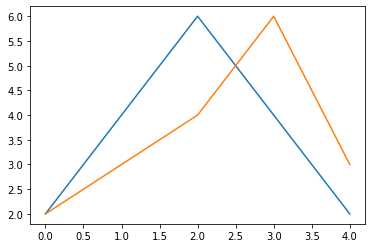

In [3]:
ts1 = [2, 4, 6, 4, 2]
ts2 = [2, 3, 4, 6, 3]
plt.plot(ts1)
plt.plot(ts2)

In [4]:
euclidean_distance = euclidean(ts1, ts2)
print('Euclidean Distance', euclidean_distance)

Euclidean Distance 3.1622776601683795


In [5]:
sum = 0
for index in range(len(ts1)):
  diff = ts1[index] - ts2[index]
  print(f'{ts1[index]} - {ts2[index]} = {diff} \t--> {diff ** 2}')
  sum = sum + diff ** 2
print('Euclidean Distance', sum ** 0.5)

2 - 2 = 0 	--> 0
4 - 3 = 1 	--> 1
6 - 4 = 2 	--> 4
4 - 6 = -2 	--> 4
2 - 3 = -1 	--> 1
Euclidean Distance 3.1622776601683795


## Alignment

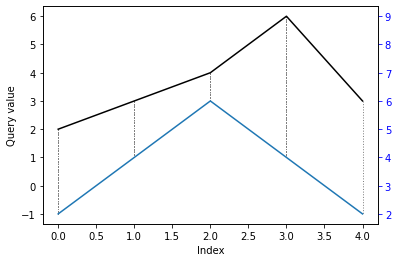

In [6]:
# Offset Plot
alignment = dtw.dtw(ts2, ts1, keep_internals=True, step_pattern=dtw.rabinerJuangStepPattern(6, 'c'))
alignment.plot(type='twoway', offset=-3)

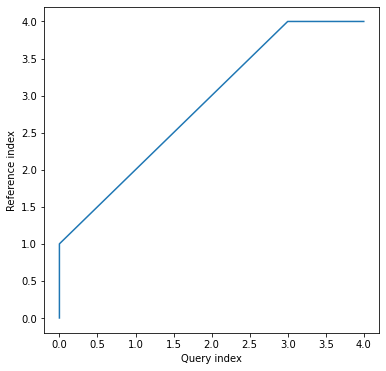

In [7]:
# Plot of the DTW process and warp path
alignment = dtw.dtw(ts1, ts2, keep_internals=True, window_type='sakoechiba', window_args={'window_size': 10})
alignment.plot()

In [8]:
# Position Alignment
for step in range(len(alignment.index1)):
  print(f'{alignment.index1[step]} -- {alignment.index2[step]}')

0 -- 0
0 -- 1
1 -- 2
2 -- 3
3 -- 4
4 -- 4


In [9]:
# Time Series Alignment
for step in range(len(alignment.index1)):
  align1 = alignment.index1[step]
  align2 = alignment.index2[step]
  print(f'{ts1[align1]} -- {ts2[align2]}')

2 -- 2
2 -- 3
4 -- 4
6 -- 6
4 -- 3
2 -- 3


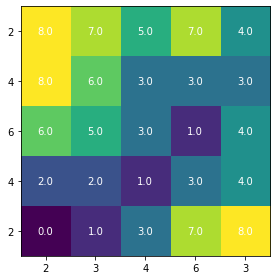

In [11]:
fig, ax = plt.subplots()
mat = np.flip(alignment.costMatrix, axis=0)
im = ax.imshow(mat)

ax.set_xticks(np.arange(len(ts2)))
ax.set_xticklabels(ts2)
ax.set_yticks(np.arange(len(ts1)))
ax.set_yticklabels(ts1[::-1])

for i in range(len(ts1)):
    for j in range(len(ts2)):
        text = ax.text(j, i, mat[i, j], ha='center', va='center', color='w')

fig.tight_layout()
plt.show()

## Challenges
* Time series could be different lengths
* Time series could be moving at different "speeds"

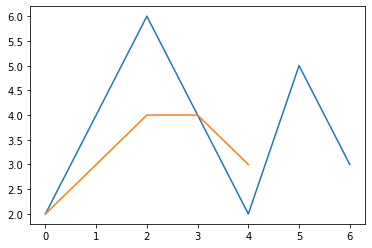

In [12]:
ts1 = [2, 4, 6, 4, 2, 5, 3]
ts2 = [2, 3, 4, 4, 3]
plt.plot(ts1)
plt.plot(ts2)

In [13]:
try:
  euclidean_distance = euclidean(ts1, ts2)
except Exception as e:
  print(e)

operands could not be broadcast together with shapes (7,) (5,) 


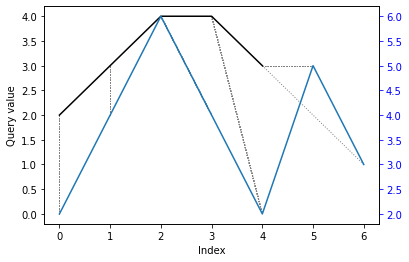

In [14]:
alignment = dtw.dtw(ts2, ts1, keep_internals=True, step_pattern=dtw.rabinerJuangStepPattern(6, 'c'))
alignment.plot(type='twoway', offset=-2)

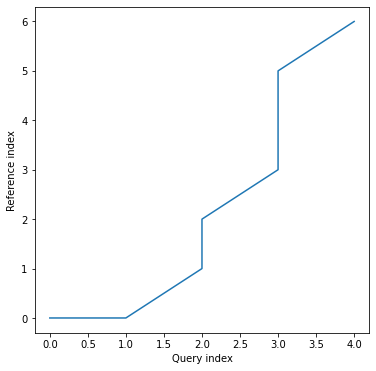

In [15]:
alignment = dtw.dtw(ts2, ts1, keep_internals=True, window_type='sakoechiba', window_args={'window_size': 10})
alignment.plot()

# Data

In [17]:
X_train_raw, y_train, X_test_raw, y_test = UCR_UEA_datasets().load_dataset('TwoPatterns')

In [18]:
print(f'Training Set Size: {X_train_raw.shape}')
print(f'Test     Set Size: {X_test_raw.shape}')

Training Set Size: (1000, 128, 1)
Test     Set Size: (4000, 128, 1)


In [19]:
X_train = pd.DataFrame(np.squeeze(X_train_raw))
X_test  = pd.DataFrame(np.squeeze(X_test_raw))

## Visualize

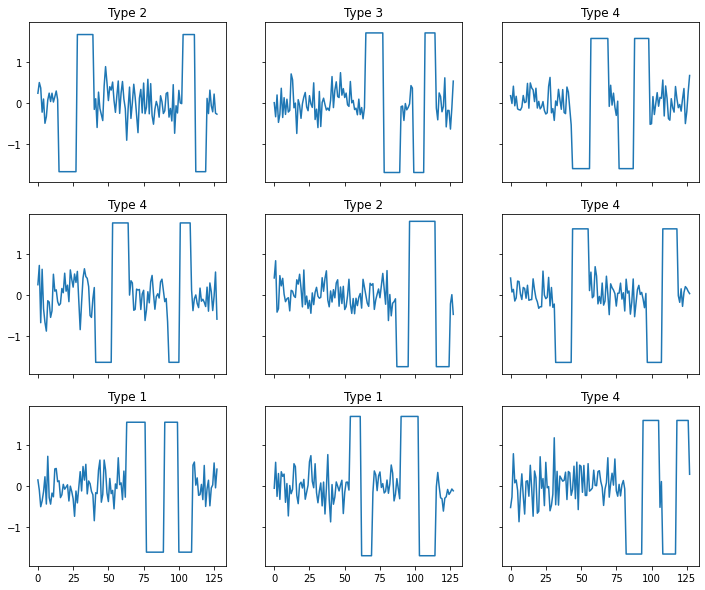

In [17]:
f, ax = plt.subplots(3, 3, sharey=True, sharex=True, figsize=(12, 10))
for index in range(9):
    ax[index // 3, index % 3].plot(X_train_raw[index])
    ax[index // 3, index % 3].set_title('Type {}'.format(y_train[index]))

## Leaderboard

In [18]:
baseline = UCR_UEA_datasets().baseline_accuracy('TwoPatterns')['TwoPatterns']
baselineDF = pd.DataFrame(baseline, index=[0]).T
baselineDF.columns=['Accuracy']
baselineDF.sort_values('Accuracy', ascending=False)[0:10]

,Accuracy
WDTW_1NN,1.00000
DTW_R1_1NN,1.00000
Flat-COTE,1.00000
EE,1.00000
DTW_F,1.00000
DD_DTW,1.00000
ERP_1NN,1.00000
HIVE-COTE,1.00000
DTD_C,0.99950
LCSS_1NN,0.99925


# Classification
* Idea -- Combine
  * Measure distance between train & test
  * Pick the minimum distance
  * Use the label from the test as our prediction
* Similarity method for two time series = DTW
* Pick closest training point (label) = KNN

## DTW-1KNN

In [19]:
TRAINING_DATAPOINTS = 20

In [20]:
X_train, y_train, X_test, y_test = UCR_UEA_datasets().load_dataset('TwoPatterns')
X_train_dtw = X_train[0:TRAINING_DATAPOINTS]
y_train_dtw = y_train[0:TRAINING_DATAPOINTS]

X_test_dtw  = X_test 
y_test_dtw  = y_test

X_train_dtw = pd.DataFrame(np.squeeze(X_train_dtw))
X_test_dtw  = pd.DataFrame(np.squeeze(X_test_dtw))

In [21]:
dtwknn = KNeighborsTimeSeries(n_neighbors=1, metric='dtw')
dtwknn.fit(X_train_dtw, y_train_dtw)
dist, index = dtwknn.kneighbors(X_test_dtw, return_distance=True)
pred = y_train_dtw[index.flatten()]

/usr/local/lib/python3.7/dist-packages/tslearn/utils/utils.py:89: UserWarning: 2-Dimensional data passed. Assuming these are 4000 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


In [22]:
accuracy_score(y_test_dtw, pred)

0.99275

## Samples & Accuracy
* Is our accuracy influenced by the number of training data points?

In [23]:
X_train, y_train, X_test, y_test = UCR_UEA_datasets().load_dataset('TwoPatterns')
X_train = pd.DataFrame(np.squeeze(X_train))
X_test  = pd.DataFrame(np.squeeze(X_test))

In [24]:
datapoints = [20, 50, 100, 200]
sizes, scores = [], []
for size in datapoints:
  X_train_dtw = X_train[0:size]
  y_train_dtw = y_train[0:size]

  dtwknn = KNeighborsTimeSeries(n_neighbors=1, metric='dtw')
  dtwknn.fit(X_train_dtw, y_train_dtw)
  dist, index = dtwknn.kneighbors(X_test_dtw, return_distance=True)
  pred = y_train_dtw[index.flatten()]
  score = accuracy_score(y_test_dtw, pred)

  sizes.append(size)
  scores.append(score)

/usr/local/lib/python3.7/dist-packages/tslearn/utils/utils.py:89: UserWarning: 2-Dimensional data passed. Assuming these are 4000 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))
/usr/local/lib/python3.7/dist-packages/tslearn/utils/utils.py:89: UserWarning: 2-Dimensional data passed. Assuming these are 4000 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))
/usr/local/lib/python3.7/dist-packages/tslearn/utils/utils.py:89: UserWarning: 2-Dimensional data passed. Assuming these are 4000 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))
/usr/local/lib/python3.7/dist-packages/tslearn/utils/utils.py:89: UserWarning: 2-Dimensional data passed. Assuming these are 4000 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))


In [25]:
pd.DataFrame({'size': sizes, 'accuracy': scores})

,size,accuracy
0,20,0.99275
1,50,0.99800
2,100,0.99975
3,200,1.00000


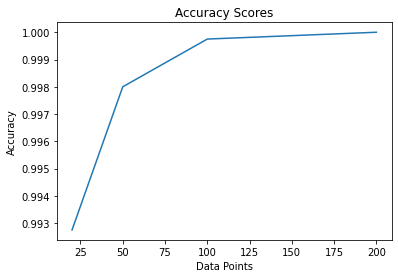

In [26]:
plt.plot(sizes, scores);
plt.title('Accuracy Scores')
plt.xlabel('Data Points')
plt.ylabel('Accuracy');

## Neighbors & Accuracy
* How does the number of neighbors affect accuracy?

In [27]:
X_train, y_train, X_test, y_test = UCR_UEA_datasets().load_dataset('TwoPatterns')
X_train = pd.DataFrame(np.squeeze(X_train))
X_test  = pd.DataFrame(np.squeeze(X_test))

In [28]:
datapoints = 20
X_train_dtw = X_train[0:datapoints]
y_train_dtw = y_train[0:datapoints]

In [29]:
candidates = [1, 2, 3, 4, 5]
neighbors, scores = [], []

for size in candidates:
  dtwknn = KNeighborsTimeSeries(n_neighbors=size, metric='dtw')
  dtwknn.fit(X_train_dtw, y_train_dtw)
  dist, index = dtwknn.kneighbors(X_test, return_distance=True)
  
  pred = np.apply_along_axis(lambda x: y_train[x], axis=1, arr=index)
  mode = np.apply_along_axis(lambda x: np.bincount(x).argmax(), axis=1, arr=pred)
  score = accuracy_score(y_test, mode)

  neighbors.append(size)
  scores.append(score)

/usr/local/lib/python3.7/dist-packages/tslearn/utils/utils.py:89: UserWarning: 2-Dimensional data passed. Assuming these are 4000 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))
/usr/local/lib/python3.7/dist-packages/tslearn/utils/utils.py:89: UserWarning: 2-Dimensional data passed. Assuming these are 4000 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))
/usr/local/lib/python3.7/dist-packages/tslearn/utils/utils.py:89: UserWarning: 2-Dimensional data passed. Assuming these are 4000 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))
/usr/local/lib/python3.7/dist-packages/tslearn/utils/utils.py:89: UserWarning: 2-Dimensional data passed. Assuming these are 4000 1-dimensional timeseries
  '{} 1-dimensional timeseries'.format(X.shape[0]))
/usr/local/lib/python3.7/dist-packages/tslearn/utils/utils.py:89: UserWarning: 2-Dimensional data passed. Assuming these are 4000 1-dimensional timeseries
  '{} 1-dimension

In [30]:
pd.DataFrame({'neighbors': neighbors, 'accuracy': scores})

,neighbors,accuracy
0,1,0.99275
1,2,0.96875
2,3,0.91125
3,4,0.83875
4,5,0.82350


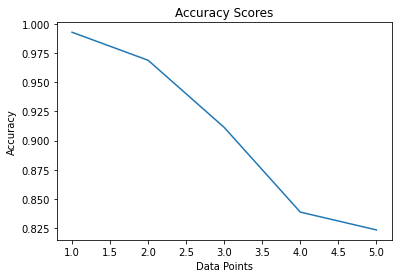

In [31]:
plt.plot(neighbors, scores);
plt.title('Accuracy Scores')
plt.xlabel('Data Points')
plt.ylabel('Accuracy');

# Clustering
* Can we learn patterns without labels?

In [32]:
X_train, y_train, X_test, y_test = UCR_UEA_datasets().load_dataset('TwoPatterns')
X_train_dtw = X_train
y_train_dtw = y_train

X_train_dtw = pd.DataFrame(np.squeeze(X_train_dtw))
X_test_dtw  = pd.DataFrame(np.squeeze(X_test_dtw))

## Euclidean Distance

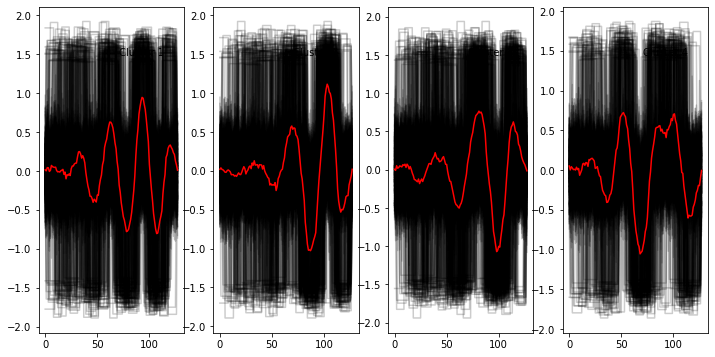

In [33]:
clusters = 4
model = TimeSeriesKMeans(n_clusters=clusters, metric='euclidean', random_state=1812)
pred = model.fit_predict(X_train_dtw)

plt.figure(figsize=(12, 6))
for yi in range(clusters):
    plt.subplot(1, clusters, yi + 1)
    for xx in X_train_dtw[pred == yi].values:
      plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(model.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1), transform=plt.gca().transAxes)

## DTW Distance

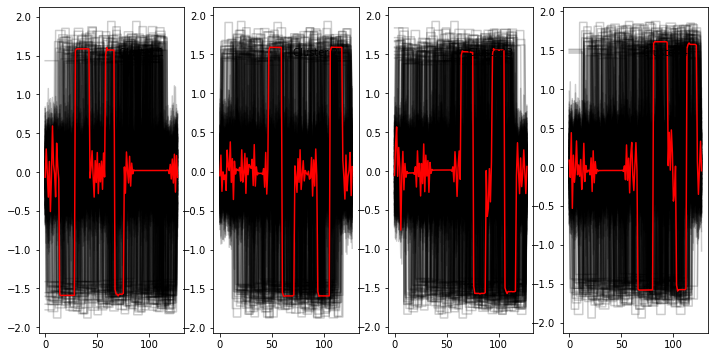

In [34]:
clusters = 4
model = TimeSeriesKMeans(n_clusters=clusters, metric='dtw', random_state=1812)
pred = model.fit_predict(X_train_dtw)

plt.figure(figsize=(12, 6))
for yi in range(clusters):
    plt.subplot(1, clusters, yi + 1)
    for xx in X_train_dtw[pred == yi].values:
      plt.plot(xx.ravel(), "k-", alpha=.2)
    plt.plot(model.cluster_centers_[yi].ravel(), "r-")
    plt.text(0.55, 0.85,'Cluster %d' % (yi + 1), transform=plt.gca().transAxes)

## Number of Clusters
* Silhouette Score - Useful when we don't have the true labels
* Higher value is more meaningful clusters

In [35]:
clusters, scores = [], []
sample_size = 250
for c in range(2, 13):
  model = TimeSeriesKMeans(n_clusters=c, metric='dtw', random_state=1812)
  pred = model.fit_predict(X_train_dtw[0:sample_size])
  score = silhouette_score(X_train_dtw[0:sample_size], pred)
  clusters.append(c)
  scores.append(score)

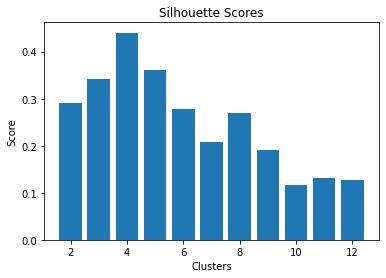

In [36]:
plt.bar(x=clusters, height=scores);
plt.title('Silhouette Scores')
plt.xlabel('Clusters')
plt.ylabel('Score');